# 决策树

In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

## 决策树的基本原理

分类任务

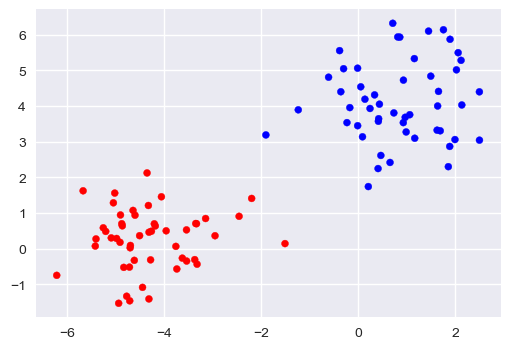

In [2]:
from sklearn.datasets import make_blobs

X, y_true = make_blobs(centers=2, random_state=3)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

ax.scatter(X[:, 0], X[:, 1], c=y_true, s=25, cmap=plt.cm.bwr)

In [3]:
_xlim = ax.get_xlim()
_ylim = ax.get_ylim()

显然，靠左边的数据属于红色类别

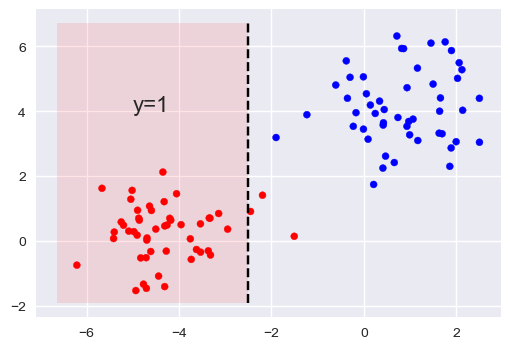

In [4]:
ax.fill_between([_xlim[0], -2.5], [_ylim[0], _ylim[0]], [_ylim[1], _ylim[1]],
                facecolor='red', alpha=0.1)
ax.plot([-2.5, -2.5], _ylim, '--k')
ax.text(-5, 4, 'y=1', fontdict=dict(fontsize=16))

fig

靠右边的数据属于蓝色类别

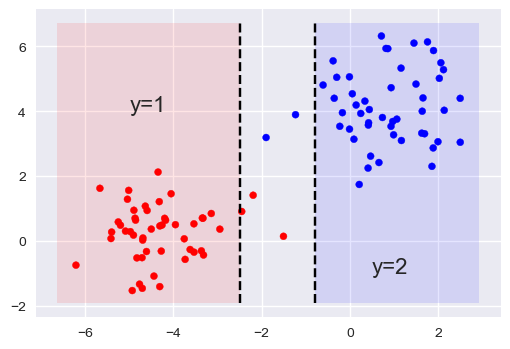

In [5]:
ax.fill_between([-0.8, _xlim[1]], [_ylim[0], _ylim[0]], [_ylim[1], _ylim[1]],
                facecolor='blue', alpha=0.1)
ax.plot([-0.8, -0.8], _ylim, '--k')
ax.text(0.5, -1, 'y=2', fontdict=dict(fontsize=16))

fig

中间的数据，上面属于蓝色类别

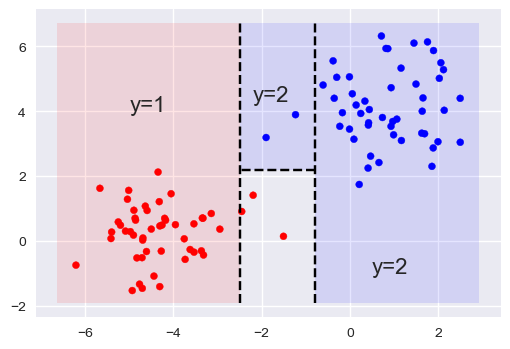

In [6]:
ax.fill_between([-0.8, -2.5], [2.2, 2.2], [_ylim[1], _ylim[1]],
                facecolor='blue', alpha=0.1)
ax.plot([-0.8, -2.5], [2.2, 2.2], '--k')
ax.text(-2.2, 4.3, 'y=2', fontdict=dict(fontsize=16))

fig

下面属于红色类别

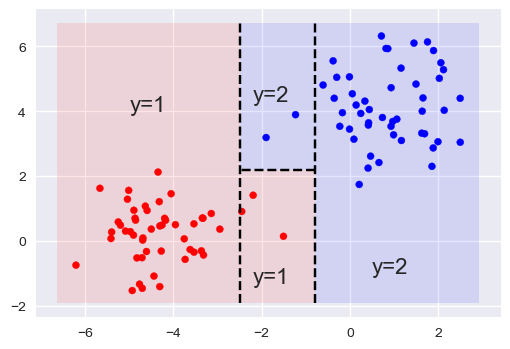

In [7]:
ax.fill_between([-0.8, -2.5], [_ylim[0], _ylim[0]], [2.2, 2.2],
                facecolor='red', alpha=0.1)
ax.text(-2.2, -1.3, 'y=1', fontdict=dict(fontsize=16))

fig

使用 Scikit-Learn 构建决策树

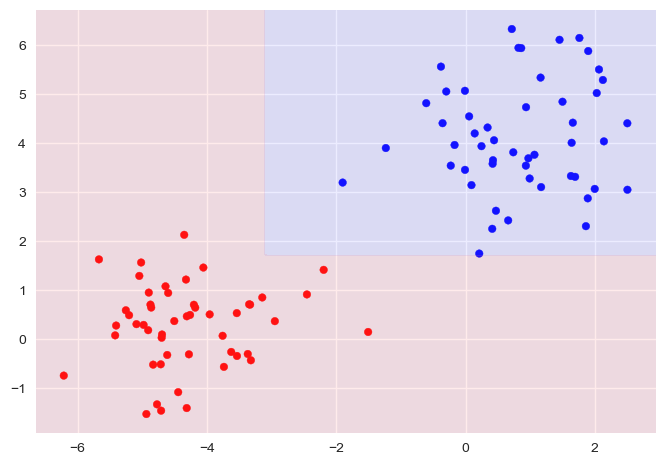

In [8]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier().fit(X, y_true)

def plot_tree_boundary(model, data_X, data_y, ax=None, **params):
    """From _Python Datascience Handbook 2018_"""
    if style_data := params.get('style_data'):
        ax.scatter(data_X[:, 0], data_X[:, 1], c=data_y, s=30, **style_data)

    X, Y = np.meshgrid(np.linspace(*ax.get_xlim(), 100),
                       np.linspace(*ax.get_ylim(), 100))
    Z = model.predict(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape)
    if style_ctf := params.get('style_ctf'):
        ax.contourf(X, Y, Z, levels=np.arange(model.n_classes_ + 1) - 0.5,
                    **style_ctf)


style_tree = dict(
    style_data=dict(cmap='bwr'),
    style_ctf=dict(cmap='bwr', alpha=0.15)
)

plot_tree_boundary(model, X, y_true, plt.gca(), **style_tree)


决策树的划分依据：基尼系数

$$ \text{Gini}(D) = \sum_{i=1}^{k} p_i(1-p_i) = 1 - \sum_{i=1}^{k} p_i^2 $$

$$ \text{Gini}(D) = \frac{S_1}{S_1 + S_2}\text{Gini}(D_1) + \frac{S_2}{S_1 + S_2}\text{Gini}(D_2) $$

决策树可用于多分类任务

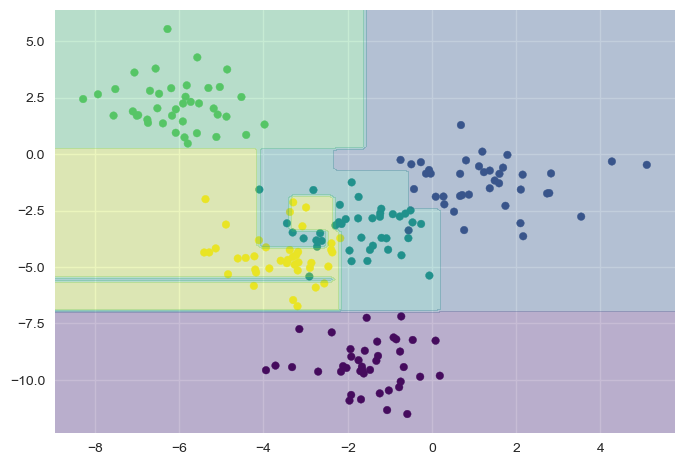

In [9]:
X, y_true = make_blobs(n_samples=200, centers=5, random_state=2)

model = DecisionTreeClassifier().fit(X, y_true)

style_multree = dict(
    style_data=dict(cmap='viridis'),
    style_ctf=dict(cmap='viridis', alpha=0.3)
)

plot_tree_boundary(model, X, y_true, plt.gca(), **style_multree)

决策树会因为每次划分选择的特征不同而产生不同的结果

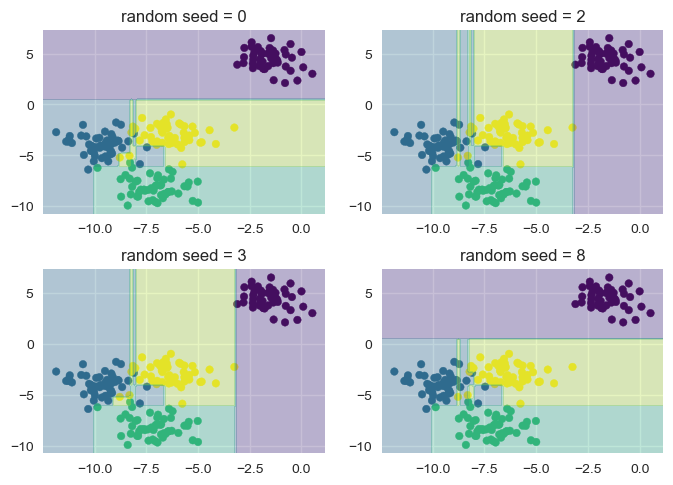

In [10]:
X, y_true = make_blobs(n_samples=200, centers=4, random_state=1)
fig, axes = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axes = axes.flatten()

for r, ax in zip([0, 2, 3, 8], axes):
    model = DecisionTreeClassifier(random_state=r).fit(X, y_true)
    ax.set_title(f'random seed = {r}')
    plot_tree_boundary(model, X, y_true, ax, **style_multree)

决策树更适用于决策边界垂直坐标轴的数据

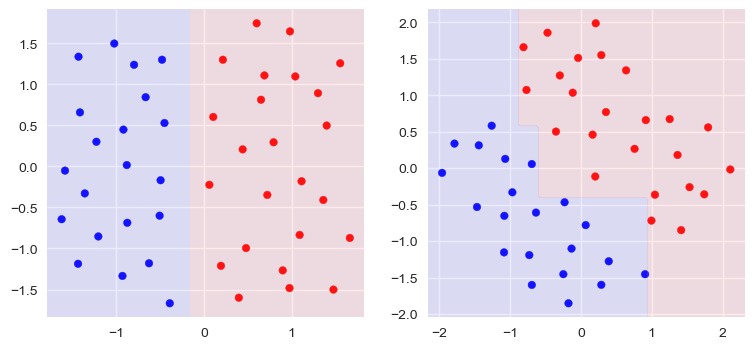

In [11]:
data6 = pd.read_csv('dataset/point dataset (6).csv')

from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(data6[['x', 'y']].values)
y = data6['label']

alpha = np.pi / 4
X_rotated = np.stack([X[:, 0] * np.cos(alpha) - X[:, 1] * np.sin(alpha),
                      X[:, 1] * np.sin(alpha) + X[:, 0] * np.cos(alpha)], axis=-1)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

model_plain = DecisionTreeClassifier().fit(X, y)
model_rotated = DecisionTreeClassifier(random_state=1).fit(X_rotated, y)

plot_tree_boundary(model_plain, X, y, axes[0], **style_tree)
plot_tree_boundary(model_rotated, X_rotated, y, axes[1], **style_tree)


## 决策树剪枝

* 前剪枝：阻止决策树过度生长

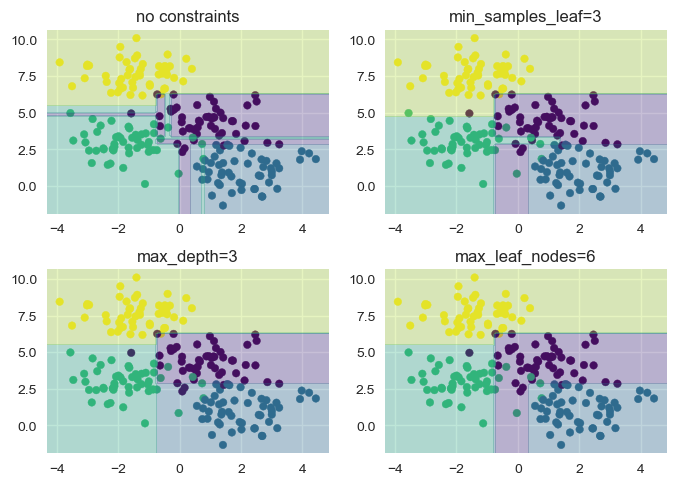

In [12]:
X, y_true = make_blobs(n_samples=200, centers=4, random_state=0)

fig, axes = plt.subplots(2, 2)
fig.subplots_adjust(hspace=0.3, wspace=0.2)
axes = axes.flatten()

tree_params = [{}, {'min_samples_leaf': 3}, {'max_depth': 3}, {'max_leaf_nodes': 6}]

for ax, param in zip(axes, tree_params):
    model = DecisionTreeClassifier(**param).fit(X, y_true)
    plot_tree_boundary(model, X, y_true, ax, **style_multree)
    ax.set_title(' '.join(map(lambda a, b: a + '=' + str(b), param.keys(), param.values())) 
                 if param else  'no constraints')

* 后剪枝：先让决策树完全生长，再剪去不必要的部分

代价复杂度剪枝(CCP)：$ \displaystyle{\alpha = \frac{R(t) - R(T)}{N(T)-1}} $ 越小表示越该剪除

In [13]:
model.cost_complexity_pruning_path(X, y_true)

{'ccp_alphas': array([0.        , 0.01873286, 0.02045571, 0.2006509 , 0.23684211]),
 'impurities': array([0.07266752, 0.09140038, 0.11185609, 0.51315789, 0.75      ])}

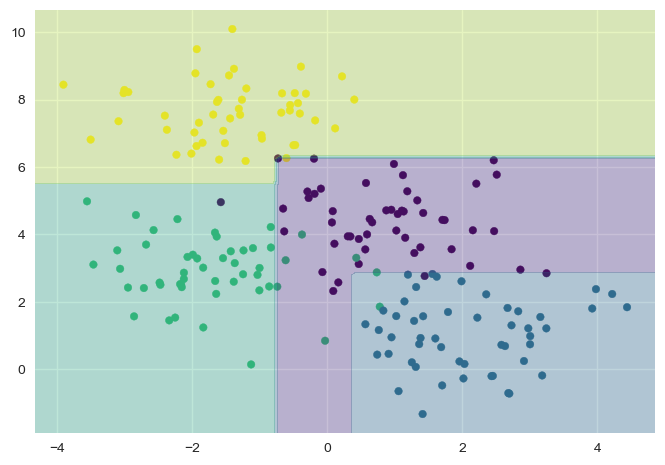

In [14]:
model = DecisionTreeClassifier(ccp_alpha=0.01).fit(X, y_true)

plot_tree_boundary(model, X, y_true, plt.gca(), **style_multree)

## Graphviz 模型可视化

将模型导出为 `.dot` 文件

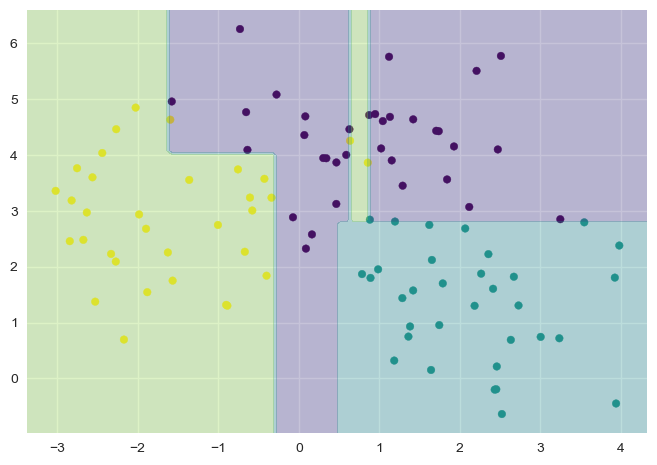

In [15]:
X, y_true = make_blobs(n_samples=100, centers=3, random_state=0)

model = DecisionTreeClassifier().fit(X, y_true)

plot_tree_boundary(model, X, y_true, plt.gca(), 
                   style_data=dict(cmap='viridis'),
                   style_ctf=dict(cmap='viridis', alpha=0.3))

from sklearn.tree import export_graphviz

export_graphviz(
    model,
    out_file='tree.dot',
    rounded=True
)


利用 Graphviz 的 `.dot` 命令行工具导出 PNG 图片

In [16]:
!dot -Tpng tree.dot -o tree.png

## 决策树回归

将预测分类改为预测值

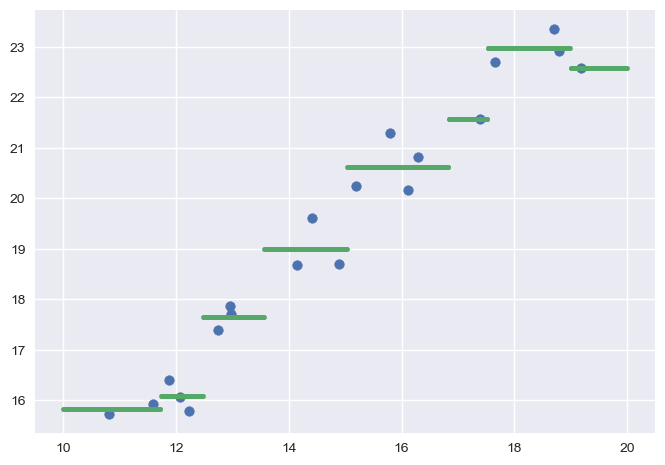

In [17]:
from sklearn.tree import DecisionTreeRegressor

rand = np.random.RandomState(5)
x = 10 * rand.rand(20) + 10
y = 0.9 * x + 6 + rand.randn(20) * 0.8
_x_range = np.linspace(10, 20, 1000)

model = DecisionTreeRegressor(max_depth=3)
model.fit(x.reshape(-1, 1), y)

plt.scatter(x, y)
plt.scatter(_x_range, model.predict(_x_range.reshape(-1, 1)),
            s=10)

原理：使均方误差最小化

$$ \text{MSE}_{\text{node}} = \sum_{i \in \text{node}} (\hat{y}_{\text{node}} - y_i)^2 $$

$$ \hat{y}_{\text{node}} = \frac{\sum_{i \in \text{node}} y_i}{n_\text{node}} $$

$$ \text{MSE} = \frac{n_{\text{left}}}{n} \text{MSE}_{\text{left}} + \frac{n_{\text{right}}}{n} \text{MSE}_{\text{right}} $$

决策树回归效果并不好，且可能导致严重过拟合

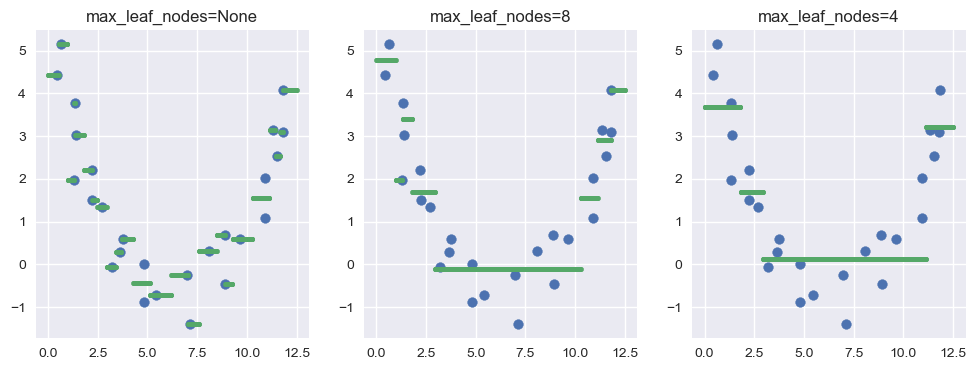

In [18]:
data7 = pd.read_csv('dataset/point dataset (7).csv')
x, y = data7['x'].values, data7['y'].values
_x_range = np.linspace(0, 12.5, 1000)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ax, param in zip(axes, [None, 8, 4]):

    model = DecisionTreeRegressor(max_leaf_nodes=param)
    model.fit(x.reshape(-1, 1), y)
    ax.set_title(f'max_leaf_nodes={param}')
    ax.scatter(x, y)
    ax.scatter(_x_range, model.predict(_x_range.reshape(-1, 1)), s=10)





In [19]:
from typing import List

class BinTree:
    n_samples = 20
    def __init__(self, left: BinTree, right: BinTree, samples: List[int]):
        self.left = left
        self.right = right
        self.samples = samples
    @property
    def ccp_alpha(self) -> float:
        if self.left is None or self.right is None:
            return 0.0
        Rt = self.rt * self.pt
        return (Rt - self.RT) / (self.n_leaves - 1)
    RT = property(lambda self: self.rt * self.pt if self.left is None or self.right is None 
                  else self.left.RT + self.right.RT)
    n_leaves = property(lambda self: 1 if self.left is None or self.right is None 
                        else self.left.n_leaves + self.right.n_leaves)
    rt = property(lambda self: 1 - max(self.samples) / sum(self.samples))
    pt = property(lambda self: sum(self.samples) / self.n_samples)
    def traverse(self, operate=None):
        if self.left is not None: self.left.traverse(operate)
        if self.right is not None: self.right.traverse(operate)
        if operate is not None: operate(self)


tree = BinTree(                         #1
    BinTree(                            #2
        BinTree(None, None, [3, 0]),    #4
        BinTree(                        #5
            BinTree(None, None, [1, 0]),#8
            BinTree(None, None, [0, 9]),#9
            [1, 9]
        ),
        [4, 9]
    ),
    BinTree(                            #3
        BinTree(None, None, [3, 0]),    #6
        BinTree(                        #7
            BinTree(None, None, [5, 0]),#10
            BinTree(None, None, [0, 3]),#11
            [5, 3]
        ),
        [8, 3]
    ),
    [12, 12]
)
tree.traverse(lambda node: print(f'{node.samples} # {node.ccp_alpha:.4f}'))

[3, 0] # 0.0000
[1, 0] # 0.0000
[0, 9] # 0.0000
[1, 9] # 0.0500
[4, 9] # 0.1000
[3, 0] # 0.0000
[5, 0] # 0.0000
[0, 3] # 0.0000
[5, 3] # 0.1500
[8, 3] # 0.0750
[12, 12] # 0.1200
